In [10]:
# 0 - EMPTY, 1 - ICE, 2 - STONE, 3 - WOOD, 4 PIG, 5/6 dynamite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import backend as K

# Load Level Data

In [11]:
def clean(entry):
    if str(entry) == "nan":
        return 0
    return min(5, int(str(entry)[0]))
vectorized_clean = np.vectorize(clean)

levels = np.array([])
key = {}
for i in range(1, 61):
    file_name = f'angry_birds_levels/level {i}.txt'
    level = pd.read_csv(file_name, sep='\t', header=None)
    cleaned_level = vectorized_clean(level)
    for col in range(cleaned_level.shape[0]):
        for row in range(cleaned_level.shape[1]):
            entry = cleaned_level[col][row]
            if entry in key:
                key[entry] += 1
            else:
                key[entry] = 1
    levels = np.append(levels, cleaned_level)

In [12]:
print(key)

total_samples = sum(key.values())
num_classes = len(key)
class_weights = {cls: total_samples / (num_classes * freq) for cls, freq in key.items()}
weights_array = np.array([class_weights[cls] for cls in sorted(key.keys())])
weights_tensor = tf.constant(weights_array, dtype=tf.float32)

print(weights_tensor)
levels = levels.reshape(-1,12,15)
print(levels.shape)
print(levels[0])

{0: 7145, 3: 1518, 4: 243, 1: 737, 2: 1144, 5: 13}
tf.Tensor(
[  0.25192443   2.4423337    1.5734266    1.1857708    7.4074073
 138.46153   ], shape=(6,), dtype=float32)
(60, 12, 15)
[[0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 4. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 3. 3. 3. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 1. 0. 1. 0. 3. 0. 0. 0. 0.]
 [3. 0. 0. 0. 3. 0. 1. 0. 1. 0. 3. 0. 0. 0. 3.]
 [3. 0. 0. 0. 3. 0. 3. 3. 3. 0. 3. 0. 0. 0. 3.]]


In [13]:
def display_level_image(tile_dim, level, tile_name_to_image):
    level_image = Image.new("RGB", (tile_dim[1] * len(level[0]), tile_dim[1] * len(level) ))
    for row in range(len(level)):
        for col in range(len(level[0])):
            level_image.paste(tile_name_to_image[level[row][col]],(col * tile_dim[0], row * tile_dim[1], (col+1) * tile_dim[0], (row +1) *tile_dim[1]))
    
    plt.figure()
    plt.imshow(level_image)
    plt.show()

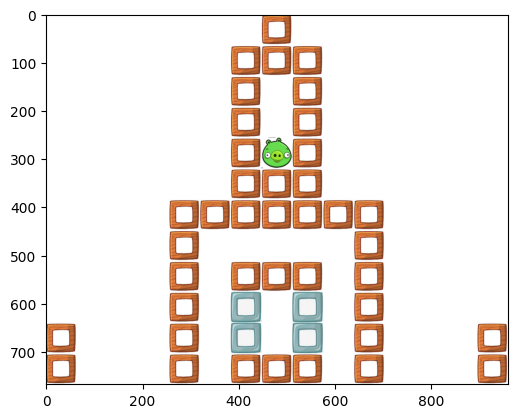

In [42]:
tile_name_to_image = {}
tiles = ["empty", "ice", "stone", "wood", "pig", "tnt"]
for i in range(len(tiles)):
    tile_name_to_image[i] = Image.open(f'angry_birds_tiles/{tiles[i]}.png')
    
tile_dim = tile_name_to_image[0].size

display_level_image(tile_dim, levels[0], tile_name_to_image)

# make network arhcitecture

In [15]:
num_classes = 6
latent_dim = 8
level_shape = (12,15,1)
dropout_rate = 0.5

# DOWN CONV with Dropout and L2 regularization
encoder_input = tf.keras.Input(shape=level_shape)
conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")(encoder_input)
conv_1 = tf.keras.layers.Dropout(dropout_rate)(conv_1)  # Add dropout
conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(conv_1)
conv_2 = tf.keras.layers.Dropout(dropout_rate)(conv_2)
conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same",activation="relu")(conv_2)
conv_3 = tf.keras.layers.Dropout(dropout_rate)(conv_3)

flatten = tf.keras.layers.Flatten()(conv_3)

# Mu and Sigma
encoder_output = tf.keras.layers.Dense(256, activation="relu")(flatten)
z_mu = tf.keras.layers.Dense(latent_dim)(encoder_output)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(encoder_output)

# sample re-param trick
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.random.normal(
        shape=(tf.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + tf.exp(z_log_sigma) * epsilon
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_sigma])

# UP CONV with reduced complexity and Dropout
dense_1 = tf.keras.layers.Dense(256, activation="relu")(z)
dense_2 = tf.keras.layers.Dense(np.prod(np.shape(conv_3)[1:]), activation="relu")(dense_1)
reshape = tf.keras.layers.Reshape(np.shape(conv_3)[1:])(dense_2)

conv_4 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding="same", activation="relu")(reshape)
conv_4 = tf.keras.layers.Dropout(dropout_rate)(conv_4)
conv_5 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding="same", activation="relu")(conv_4)
conv_5 = tf.keras.layers.Dropout(dropout_rate)(conv_5)
conv_6 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, padding="same", activation="relu")(conv_5)

decoder_output = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=3, padding="same", activation="softmax")(conv_6)
flattened_output = tf.keras.layers.Reshape((12 * 15 * num_classes,))(decoder_output)

concattenated_output = tf.keras.layers.Concatenate()([flattened_output, z_mu, z_log_sigma])

def vae_loss(y_true, output, kl_loss_weight=0.1):
    y_pred = output[:,0:12*15*num_classes]
    y_pred = tf.reshape(y_pred, shape=(-1, 12, 15, num_classes))

    z_mu = output[:,12*15*num_classes: 12*15*num_classes + latent_dim]
    z_log_sigma = output[:,12*15*num_classes + latent_dim: 12*15*num_classes + latent_dim*2]
    
    reconstruction_loss = tf.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(y_true, y_pred))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_sigma - z_mu**2 - tf.exp(z_log_sigma), axis=-1)
    res = kl_loss_weight * kl_loss + reconstruction_loss
    return res
        
# Model compilation
vae_cnn = tf.keras.Model(inputs=encoder_input, outputs=concattenated_output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae_cnn.compile(optimizer=optimizer, loss=vae_loss)
vae_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 12, 15, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 15,    │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 12, 15,    │          0 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 15,    │      4,640 │ dropout_5[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 15,    │          0 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 15,    │      9,248 │ dropout_6[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 12, 15,    │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5760)      │          0 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │  1,474,816 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │      2,056 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │      2,056 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 8)         │          0 │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │      2,304 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5760)      │  1,480,320 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 12, 15,    │          0 │ dense_9[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 12, 15,    │      9,248 │ reshape_2[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 12, 15,    │          0 │ conv2d_transpose… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 12, 15,    │      9,248 │ dropout_8[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 12, 15,    │          0 │ conv2d_transpose

 Total params: 2,999,590 (11.44 MB)

 Trainable params: 2,999,590 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
x = levels.reshape((levels.shape[0], levels.shape[1], levels.shape[2], 1))

vae_cnn.fit(x=x, y=x, epochs=250, batch_size=16, validation_split=0.1)

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 1.7956 - val_loss: 1.7684
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.7406 - val_loss: 1.7160
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.6118 - val_loss: 1.6085
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.5272 - val_loss: 1.5396
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.4127 - val_loss: 1.4588
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.3242 - val_loss: 1.3739
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.2693 - val_loss: 1.3425
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.2393 - val_loss: 1.3152
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.2066 - val_loss: 1.3099
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.1269 - val_loss: 1.2301
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.1717 - val_loss: 1.2844
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.1136 - val_l

# Generate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(12, 15, 6)


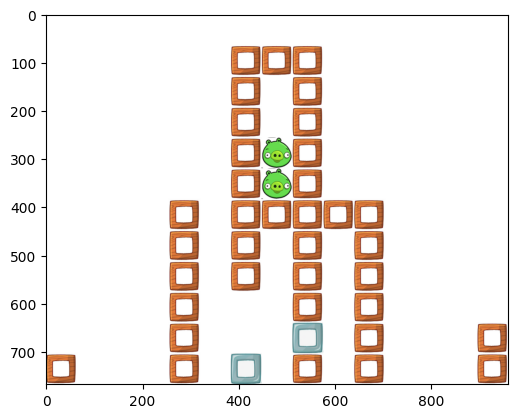

In [41]:
test = x[0]
gen = vae_cnn.predict(test.reshape(1,12,15,1))[0][:12*15*6].reshape((12,15,num_classes))
print(gen.shape)

generated_level = np.argmax(gen, axis=2)

display_level_image(tile_dim, generated_level, tile_name_to_image)

In [44]:
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoder_layer = vae_cnn.layers[-11](decoder_input)
decoder_layer = vae_cnn.layers[-10](decoder_layer)
decoder_layer = vae_cnn.layers[-9](decoder_layer)
decoder_layer = vae_cnn.layers[-8](decoder_layer)
decoder_layer = vae_cnn.layers[-7](decoder_layer)
decoder_layer = vae_cnn.layers[-6](decoder_layer)
decoder_layer = vae_cnn.layers[-5](decoder_layer)
decoder_layer = vae_cnn.layers[-4](decoder_layer)
decoder_layer = vae_cnn.layers[-3](decoder_layer)
decoder = tf.keras.Model(decoder_input, decoder_layer)

encoder = tf.keras.Model(encoder_input, z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


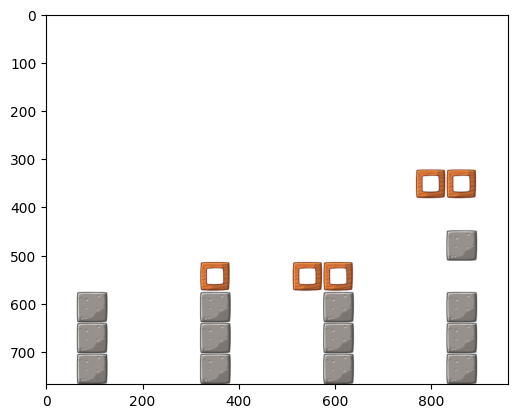

In [80]:
vector_one = encoder.predict(np.array(x[0]).reshape(1, 12, 15, 1))[0]
vector_two = encoder.predict(np.array(x[1]).reshape(1, 12, 15, 1))[0]

a = 0.3
vector = vector_one * a + vector_two * (1-a)

gen = decoder.predict(np.array(vector).reshape(1,latent_dim))[0]
generated_level = np.argmax(gen, axis=2)
display_level_image(tile_dim, generated_level, tile_name_to_image)